In [1]:
# All neccessary imports
import pandas as pd
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from gensim.models import KeyedVectors
import numpy as np
import requests
import csv
from numpy.linalg import norm


import tensorflow as tf
import keras.backend as K
import keras

from keras.layers import Bidirectional, SimpleRNN, LSTM, Dense, Concatenate, Input, Attention
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt




In [2]:
# Choose loss method and amount of data to use to train the model
# As well as the operating system you are using

### Choose Loss Method ###
method = "regression" ## Cosine Similarity
# method = "classification" ## Categorical Crossentropy

### Choose Amount of Data to Use ###
num_samples = 1000 ## Small Data

### Choose Operating System ###
# os = "Windows"
os = "Mac"

In [3]:
# Globals

download_link = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

In [4]:
# Download the dataset

if os == "Windows":
    # For Windows
    SQuAD = pd.read_json(download_link)
    SQuAD = SQuAD.drop("version", axis='columns')
    SQuAD.head()
    
elif os == "Mac":
    # For Mac
    response = requests.get(download_link)
    with open('train-v2.0.json', 'wb') as f:
        f.write(response.content)
    SQuAD = pd.read_json('train-v2.0.json')

In [5]:
# Clean the dataset by removing columns that we do not need. We will only keep the question, the respective answer and the context used for the response
# Code from: https://www.pragnakalp.com/nlp-tutorial-setup-question-answering-system-bert-squad-colab-tpu/

columns_to_keep = ["text","question","answer"]
 
data_to_keep = []
for index, row in SQuAD.iterrows():
   for i in range(len(row['data']['paragraphs'])):
       for j in (row['data']['paragraphs'][i]['qas']):
           temp_list = []
           temp_list.append((row["data"]["paragraphs"][i]["context"]))
           temp_list.append(j['question'])
           if j["answers"]:
               temp_list.append(j["answers"][0]["text"])
           else:
               temp_list.append("")
       data_to_keep.append(temp_list)
df = pd.DataFrame(data_to_keep, columns=columns_to_keep)
df.head()

,text,question,answer
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What was the name of Beyoncé's first solo album?,Dangerously in Love
1,Following the disbandment of Destiny's Child i...,What is the name of Beyoncé's alter-ego?,Sasha Fierce
2,"A self-described ""modern-day feminist"", Beyonc...",What magazine named Beyoncé as the most powerf...,Forbes
3,"Beyoncé Giselle Knowles was born in Houston, T...",Beyoncé was raised in what religion?,Methodist
4,Beyoncé attended St. Mary's Elementary School ...,What choir did Beyoncé sing in for two years?,St. John's United Methodist Church


In [6]:
# Cleaning the text by converting characters to lowercase, removing punctuation, filtering out short tokens
# Code from tutorial/lab 2

def clean_text(doc):
    # Convert all characters to lowercase
    doc = doc.lower()

    # Replace all punctuation with a space
    for char in string.punctuation:
        doc = doc.replace(char, ' ')

    # Split the text into tokens (words) using white space as a delimiter
    tokens = doc.split()

    # Filter out short tokens (length <= 1)
    tokens = [word for word in tokens if len(word) > 1]

    # Join the tokens back into a single string with spaces in between
    doc = " ".join(tokens)

    return doc

def clean_df(df):
    # Initialize an empty list, cleaned_df
    cleaned_df = []

    # Iterate over each text in the 'text' column of the DataFrame
    for text in tqdm(df['essay']):
        # Apply the clean_text function to each text
        clean = clean_text(text)

        # Append the cleaned text to the cleaned_df list
        cleaned_df.append(clean)

    # Return the cleaned_df list
    return cleaned_df

In [7]:
# Apply the cleaning pre-processing to the text (context), question and answer columns

cleaned_df = df
cleaned_df['text'] = df['text'].apply(lambda x: clean_text(x))
cleaned_df['question'] = df['question'].apply(lambda x: clean_text(x))
cleaned_df['answer'] = df['answer'].apply(lambda x: clean_text(x))

In [8]:
cleaned_df.head()

,text,question,answer
0,beyoncé giselle knowles carter biːˈjɒnseɪ bee ...,what was the name of beyoncé first solo album,dangerously in love
1,following the disbandment of destiny child in ...,what is the name of beyoncé alter ego,sasha fierce
2,self described modern day feminist beyoncé cre...,what magazine named beyoncé as the most powerf...,forbes
3,beyoncé giselle knowles was born in houston te...,beyoncé was raised in what religion,methodist
4,beyoncé attended st mary elementary school in ...,what choir did beyoncé sing in for two years,st john united methodist church


In [9]:
# remove any rows that have empty answers
cleaned_df = cleaned_df[cleaned_df['answer'] != '']

CUTOFF_TRAIN_TEST = int(len(cleaned_df) * 80 / 100)
train_data = cleaned_df[0:CUTOFF_TRAIN_TEST]
test_data = cleaned_df[CUTOFF_TRAIN_TEST:len(cleaned_df)]

# show the validation data
test_data.head()

,text,question,answer
15041,fundamental part of gaddafi ideology was anti ...,what was major factor in gaddafi hatred of the...,support of israel
15042,gaddafi was very private individual who descri...,who remarked on gaddafi family orientation,his father
15043,in the 1970s and 1980s there were reports of h...,what book was written by annick cojean,gaddafi harem
15044,following his ascension to power gaddafi moved...,how much did gaddafi pay for his airbus a340,120 million
15045,gaddafi married his first wife fatiha al nuri ...,when did khamis gaddafi die,2011


In [10]:
# Write validation answers to a csv file
test_data.to_csv('test_data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [11]:
# Write the training data to a csv file
train_data.to_csv('train_data.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [12]:
# Example path, ensure you have the model downloaded
diana_path = 'D:/AI year 3/NLP/Tutorials/nlp-2024/GoogleNews-vectors-negative300.bin'
vojo_path = '/Users/vojislavwestmoreland/Desktop/AI/Yr_3/Term 3/NLP/GoogleNews-vectors-negative300.bin'

word_vectors = KeyedVectors.load_word2vec_format(vojo_path, binary=True)

In [13]:
# Function to convert text to feature vectors
def text_to_feature_vector(text, method, max_length):
    words = text.split()
    # Initialize an empty list to store the word vectors with size of the max_length and 300 columns
    if method == "raw":
        feature_vector_raw = np.zeros((max_length, 300))
        index = 0
        for word in words:
            if word in word_vectors:
                # Add the word vector to the feature vector list
                feature_vector_raw[index] = word_vectors[word]
                index += 1
    

    feature_vector = feature_vector_raw

    return feature_vector

In [14]:
def doc_to_feature_vector(train, method, max_length):
    train_vectors = []
    index = 0
    for text in train:
        index += 1
        # Get the feature vector for the text
        text_seq_vector = text_to_feature_vector(text, method, max_length)
        train_vectors.append(text_seq_vector)

    return train_vectors


In [15]:
def convert_to_vectors(data, method, max_length):
    processed = np.array(doc_to_feature_vector(data, method, max_length))
    return processed

In [16]:
def max_length(data):
    max_length = 0
    for text in data:
        if len(text.split()) > max_length:
            max_length = len(text.split())
    return max_length

In [17]:
# Set the max length of the context, question and answer to the longest text in the training data
max_context_length = int(max_length(train_data['text']))
max_question_length = int(max_length(train_data['question']))
max_answer_length = int(max_length(train_data['answer']))

In [18]:
BOS_EOS = np.ones(300)
SEP = np.full(300, 2)
MAX_LEN = max_context_length + max_question_length + 2 # Maximum sequence length, the +1 is for the indicator between the context and question +1 for EOS
MAX_LEN_ANSWER = max_answer_length + 1 # Maximum sequence length, the +1 is for the end token

In [19]:
def convert_data(amount, num_samples):
    # Split the data into 4 parts because of memory issues with context since its so large
    # For now I am only converting the first 1000 questions and contexts

    if amount == "all":
        question1 = convert_to_vectors(train_data['question'], "raw", max_question_length)
        context1 = convert_to_vectors(train_data['text'], "raw", max_context_length)
        answer1 = convert_to_vectors(train_data['answer'], "raw", max_answer_length)
    else:
        question1 = convert_to_vectors(train_data['question'][0:num_samples], "raw", max_question_length)
        context1 = convert_to_vectors(train_data['text'][0:num_samples], "raw", max_context_length)
        answer1 = convert_to_vectors(train_data['answer'][0:num_samples], "raw", max_answer_length)

    # Convert the validation data
    question_val = convert_to_vectors(test_data['question'][0:50], "raw", max_question_length)
    context_val = convert_to_vectors(test_data['text'][0:50], "raw", max_context_length)
    answer_val = convert_to_vectors(test_data['answer'][0:50], "raw", max_answer_length)

    return question1, context1, answer1, question_val, context_val, answer_val

In [20]:
def create_one_hot_dic():
    # Get all words in the context and question to build a dictionary for one hot encoding
    all_words = []
    for text in train_data['text'][0:num_samples]:
        for word in text.split():
            all_words.append(word)

    for text in train_data['question'][0:num_samples]:
        for word in text.split():
            all_words.append(word)

    # Get the unique words
    unique_words = set(all_words)

    one_hot = pd.get_dummies(list(unique_words))

    # create dictionary of words and their respective one hot encoding
    word_to_one_hot = {}
    for word in unique_words:
        word_to_one_hot[word] = one_hot[word]  # Access by column name

    return word_to_one_hot, one_hot

In [21]:
def answers_to_one_hot(word_to_one_hot, one_hot, num_samples):
    # Convert first 200 answers to one hot encoding, since memory is an issue
    answer1_one_hot = []
    for answer in train_data['answer'][0:num_samples]:
        answer_one_hot = []
        for i in range(max_answer_length):
            if i < len(answer.split()):
                word = answer.split()[i]
                if word in word_to_one_hot:
                    answer_one_hot.append(word_to_one_hot[word])
            else:
                answer_one_hot.append(np.zeros(one_hot.shape[1]))
        answer1_one_hot.append(answer_one_hot)

    # Convert first 50 validation answers to one hot encoding
    answer_val_one_hot = []
    for answer in test_data['answer'][0:50]:
        answer_one_hot = []
        for i in range(max_answer_length):
            if i < len(answer.split()):
                word = answer.split()[i]
                if word in word_to_one_hot:
                    answer_one_hot.append(word_to_one_hot[word])
            else:
                answer_one_hot.append(np.zeros(one_hot.shape[1]))
        answer_val_one_hot.append(answer_one_hot)

    return answer1_one_hot, answer_val_one_hot

In [22]:
def add_separator_one_hot(answer1_one_hot, max_answer_length, one_hot):
    # Add <BOS> to the start of the answer
    EOS_OH = np.zeros((1, one_hot.shape[1]))

    answer_one_hot_output = answer1_one_hot

    # Convert to numpy array
    answer_one_hot_output = np.array(answer_one_hot_output)

    # Add <EOS> to the end of the answer
    answer_one_hot_output = np.insert(answer_one_hot_output, max_answer_length, EOS_OH, axis=1)

    return answer_one_hot_output

In [23]:
def add_separators_to_embeddings(context1, question1, answer1, context_val, question_val):
    # Add a separator after the context
    contexts = np.insert(context1, len(context1[1]), SEP, axis=1)
    # Concatenate context and questions, so that we have context + SEP + question
    context_and_question = np.concatenate((contexts, question1), axis=1)
    # Add EOS_BOS at the end to get context + SEP + question + EOS/BOS
    context_and_question = np.insert(context_and_question, len(context_and_question[1]), BOS_EOS, axis=1)

    # Add EOS_BOS at the end of the answers
    answers_output = np.insert(answer1, len(answer1[1]), BOS_EOS, axis=1)
    answers_input = np.insert(answer1, 0, BOS_EOS, axis=1)

    # Add a separator after the context for the validation data
    context_val = np.insert(context_val, len(context_val[1]), SEP, axis=1)
    # Concatenate context and questions, so that we have context + SEP + question
    context_and_question_val = np.concatenate((context_val, question_val), axis=1)
    # Add EOS_BOS at the end to get context + SEP + question + EOS_BOS
    context_and_question_val = np.insert(context_and_question_val, len(context_and_question_val[1]), BOS_EOS, axis=1)

    return context_and_question, answers_output, answers_input, context_and_question_val

In [24]:
# Prepare the data for the model

# For vector embeddings
questions, contexts, answers, questions_val, contexts_val, answers_val = convert_data("subset", num_samples)
context_and_question, answers_output, answers_input, context_and_question_val = add_separators_to_embeddings(contexts, questions, answers, contexts_val, questions_val)

if method == "classification":
    # For one hot encoding
    word_to_one_hot, one_hot = create_one_hot_dic()
    answer_one_hot, answer_val_one_hot = answers_to_one_hot(word_to_one_hot, one_hot, num_samples)
    answer_one_hot_output = add_separator_one_hot(answer_one_hot, max_answer_length, one_hot)

In [25]:
EMBEDDING_DIM = 300  # Dimension of the word embeddings
EPOCHS = 5
BATCH_SIZE = 128

if method == "classification":
    NUM_CLASSES = one_hot.shape[1]

In [26]:
# Structure of the model
def build_simple_rnn(method):
    
    # Define the input shapes
    enc_input_shape = (None, EMBEDDING_DIM)
    dec_input_shape = (None, EMBEDDING_DIM)

    # Define the inputs
    enc_inputs = Input(shape=enc_input_shape)
    dec_inputs = Input(shape=dec_input_shape)

    # Encoder layer 1
    encoder1 = Bidirectional(LSTM(512, return_sequences=True, return_state=True), merge_mode='concat')
    encoder_outputs_1, forward_h_1, forward_c_1, backward_h_1, backward_c_1 = encoder1(enc_inputs)
    concat_h_1 = Concatenate()([forward_h_1, backward_h_1])
    concat_c_1 = Concatenate()([forward_c_1, backward_c_1])
    
    # Encoder layer 2
    encoder_2 = Bidirectional(LSTM(512, return_sequences=True, return_state=True), merge_mode='concat')
    encoder_outputs_2, forward_h_2, forward_c_2, backward_h_2, backward_c_2 = encoder_2(encoder_outputs_1)
    concat_h_2 = Concatenate()([forward_h_2, backward_h_2])
    concat_c_2 = Concatenate()([forward_c_2, backward_c_2])

    # Decoder layer 1
    decoder_1 = LSTM(1024, return_sequences=True, return_state=True)
    decoder_output_1, _, _ = decoder_1(dec_inputs, initial_state=[concat_h_1, concat_c_1])

    # Decoder layer 1
    decoder_2 = LSTM(1024, return_sequences=True, return_state=True)
    decoder_output_2, _, _ = decoder_2(decoder_output_1, initial_state=[concat_h_2, concat_c_2])

    attention = Attention()
    context_vector = attention([decoder_output_2, encoder_outputs_2])

    decoder_combined_context = tf.concat([context_vector, decoder_output_2], axis=-1)

    if method == "regression":
        ### Output for regression ###
        dense = Dense(EMBEDDING_DIM, activation='linear')
        output = dense(decoder_combined_context)

    if method == "classification":
        ### Output for classification ###
        dense = Dense(NUM_CLASSES, activation='softmax')
        output = dense(decoder_combined_context)

    # Model
    model = keras.Model(inputs=[enc_inputs, dec_inputs], outputs=output)
    
    return model

In [27]:
def loss_function(y_true, y_pred):
    cos_sim_total = 0
    max_len_answer = y_true.shape[1]
    for i in range(max_len_answer):
        Y_true_row = y_true[:, i, :]
        Y_pred_row = y_pred[:, i, :]
        
        # Flatten the row tensors
        Y_true_row_flat = K.reshape(Y_true_row, (-1, 300))
        Y_pred_row_flat = K.reshape(Y_pred_row, (-1, 300))
        
        # Compute cosine similarity for the current row
        cos_sim_row = keras.losses.cosine_similarity(Y_true_row_flat, Y_pred_row_flat)
        # Add the cosine similarity to the total
        cos_sim_total += cos_sim_row

    # Return the negative of the total cosine similarity since we want to minimize cosine similarity
    # And a cosine similarity of 1 is the best and -1 is the worst
    mean_cos_sim = cos_sim_total / max_len_answer
    return -mean_cos_sim


In [28]:
def train_model(method):
    build_simple_rnn(method).summary()
    base_model = build_simple_rnn(method)

    if method == "regression":
        base_model.compile(optimizer='rmsprop', loss=loss_function, metrics=['accuracy'])
        history = base_model.fit([context_and_question, answers_input], answers_output,  epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)
    if method == "classification":
        base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        print("Shape of context and question", context_and_question.shape)
        print("Shape of answers input", answers_input.shape)
        print("Shape of answer one hot output", answer_one_hot_output.shape)
        history = base_model.fit([context_and_question, answers_input], answer_one_hot_output,  epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)


    return history, base_model


In [29]:
def plot_train_history(history):
    # Plot the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 300)]          0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, None, 1024),         3330048   ['input_1[0][0]']             
 al)                          (None, 512),                                                        
                              (None, 512),                                                        
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                              

2024-04-08 16:56:34.732495: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - ETA: 0s - loss: -0.0406 - accuracy: 7.9365e-05 

2024-04-08 16:59:55.638324: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - 210s 26s/step - loss: -0.0406 - accuracy: 7.9365e-05 - val_loss: -0.0507 - val_accuracy: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 175s 21s/step - loss: -0.0549 - accuracy: 0.0000e+00 - val_loss: -0.0495 - val_accuracy: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 163s 20s/step - loss: -0.0548 - accuracy: 0.0000e+00 - val_loss: -0.0488 - val_accuracy: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 179s 22s/step - loss: -0.0525 - accuracy: 0.0000e+00 - val_loss: -0.0521 - val_accuracy: 0.0000e+00
Epoch 5/5
8/8 [==============================] - 165s 20s/step - loss: -0.0553 - accuracy: 0.0000e+00 - val_loss: -0.0495 - val_accuracy: 0.0000e+00


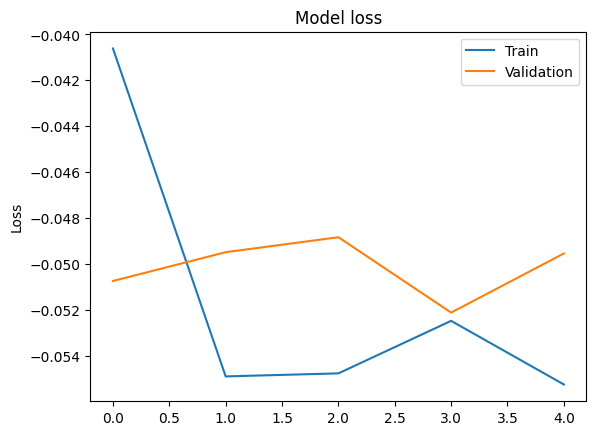

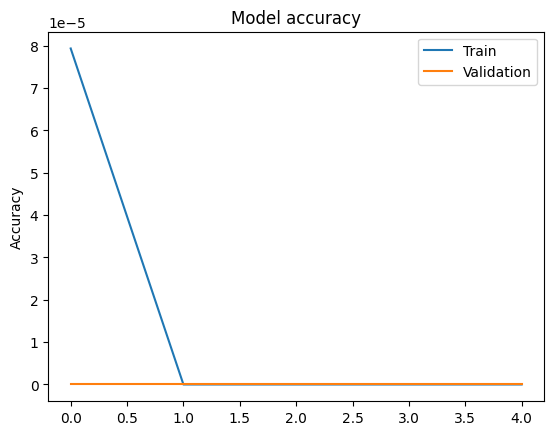

In [30]:
# Train the model

history, base_model = train_model(method)
plot_train_history(history)


In [31]:
if method == "classification":
    # Output predictions for classification model on validation data
    real_word_outputs = []
    file_name = "Predicted_Outputs_Classification.csv"

    with open(file_name, mode='a') as file:

        # Get the real words from the word vectors
        for i in range(len(context_and_question_val)):
            print("Processing text", i, "of", len(context_and_question_val))
            real_word_output = []
            testing_input = [context_and_question_val[i:i+1]]

            # Input the context and question into the first LSTM layer in the model
            encoder_outputs_1, state_h_f1, state_c_f1, state_h_b1, state_c_b1  = base_model.layers[1](testing_input)
            concat_h_1 = base_model.layers[3]([state_h_f1, state_h_b1])
            concat_c_1 = base_model.layers[4]([state_c_f1, state_c_b1])

            # Input the hidden states and the encoder output into the second LSTM layer in the model
            encoder_outputs_2, state_h_f2, state_c_f2, state_h_b2, state_c_b2  = base_model.layers[5](encoder_outputs_1)
            concat_h_2 = base_model.layers[7]([state_h_f2, state_h_b2])
            concat_c_2 = base_model.layers[8]([state_c_f2, state_c_b2])

            # Initialize the decoder input to BOS
            dec_input = np.zeros((1, 1, 300))
            for j in range(MAX_LEN_ANSWER):
                # Input the decoder input and the hidden states into the decoder LSTM layers
                decoder_output_1, _, _ = base_model.layers[6](dec_input, initial_state=[concat_h_1, concat_c_1])
                decoder_output_2, _, _ = base_model.layers[9](decoder_output_1, initial_state=[concat_h_2, concat_c_2])

                # Get the attention weights
                attention_weights = base_model.layers[10]([decoder_output_2, encoder_outputs_2])
                # Concatenate the attention weights and the decoder output
                decoder_combined_context = tf.concat([attention_weights, decoder_output_2], axis=-1)

                # Get the predicted word from the dense layer
                pred_word_vector = base_model.layers[12](decoder_combined_context)

                # Get the index of the word vector with the highest value
                pred_word_index = np.argmax(pred_word_vector)
        
                # Get the word from the one hot encoding
                pred_word = one_hot.columns[pred_word_index]
                real_word_output.append(pred_word) 

                if pred_word in word_vectors:
                    dec_input = word_vectors[pred_word]
                else:
                    # If the word is not in the word vectors, set the decoder input to zeros
                    dec_input = np.zeros((1, 1, 300))
                
                dec_input = dec_input.reshape(1, 1, -1)

            writer = csv.writer(file)
            writer.writerow(real_word_output)

In [32]:
if method == "regression":
    # Getting real word outputs for regression model on validation data
    real_word_outputs = []
    file_name = "Predicted_Outputs_Regression.csv"

    start_vector_sim = word_vectors.similar_by_vector(BOS_EOS, topn=1)
    start_vector_word = start_vector_sim[0][0]
    end_vector_sim = word_vectors.similar_by_vector(BOS_EOS, topn=1)
    end_vector_word = end_vector_sim[0][0]

    with open(file_name, mode='a') as file:

        # Get the real words from the word vectors
        for i in range(len(context_and_question_val)):
            print("Processing text", i, "of", len(context_and_question_val))
            real_word_output = []
            testing_input = [context_and_question_val[i:i+1]]

            # Input the context and question into the first LSTM layer in the model
            encoder_outputs_1, state_h_f1, state_c_f1, state_h_b1, state_c_b1  = base_model.layers[1](testing_input)
            concat_h_1 = base_model.layers[3]([state_h_f1, state_h_b1])
            concat_c_1 = base_model.layers[4]([state_c_f1, state_c_b1])

            # Input the hidden states and the encoder output into the second LSTM layer in the model
            encoder_outputs_2, state_h_f2, state_c_f2, state_h_b2, state_c_b2  = base_model.layers[5](encoder_outputs_1)
            concat_h_2 = base_model.layers[7]([state_h_f2, state_h_b2])
            concat_c_2 = base_model.layers[8]([state_c_f2, state_c_b2])

            # Initialize the decoder input to BOS
            dec_input = np.zeros((1, 1, 300))
            for j in range(MAX_LEN_ANSWER):
                # Input the decoder input and the hidden states into the decoder LSTM layers
                decoder_output_1, _, _ = base_model.layers[6](dec_input, initial_state=[concat_h_1, concat_c_1])
                decoder_output_2, _, _ = base_model.layers[9](decoder_output_1, initial_state=[concat_h_2, concat_c_2])

                # Get the attention weights
                attention_weights = base_model.layers[10]([decoder_output_2, encoder_outputs_2])
                # Concatenate the attention weights and the decoder output
                decoder_combined_context = tf.concat([attention_weights, decoder_output_2], axis=-1)

                # Get the predicted word from the dense layer
                pred_word_vector = base_model.layers[12](decoder_combined_context)

                # Its a 3D array, so we need to get the first element of the first element or smthn
                pred_word_vector = pred_word_vector[0][0]
                pred_word_vector_array = pred_word_vector.numpy()

                # Get the predicted word from the word vector
                pred_word = word_vectors.similar_by_vector(pred_word_vector_array, topn=1)
                pred_word = pred_word[0][0]
                if pred_word != start_vector_word and pred_word != end_vector_word:
                    real_word_output.append(pred_word)
                if pred_word == end_vector_word:
                    break
                # Get next decoder input
                dec_input = np.array([[pred_word_vector]])

            writer = csv.writer(file)
            writer.writerow(real_word_output)
        

Processing text 0 of 50
Processing text 1 of 50
Processing text 2 of 50
Processing text 3 of 50
Processing text 4 of 50
Processing text 5 of 50
Processing text 6 of 50
Processing text 7 of 50
Processing text 8 of 50
Processing text 9 of 50
Processing text 10 of 50
Processing text 11 of 50
Processing text 12 of 50
Processing text 13 of 50
Processing text 14 of 50
Processing text 15 of 50
Processing text 16 of 50
Processing text 17 of 50
Processing text 18 of 50
Processing text 19 of 50
Processing text 20 of 50
Processing text 21 of 50
Processing text 22 of 50
Processing text 23 of 50
Processing text 24 of 50
Processing text 25 of 50
Processing text 26 of 50
Processing text 27 of 50
Processing text 28 of 50
Processing text 29 of 50
Processing text 30 of 50
Processing text 31 of 50
Processing text 32 of 50
Processing text 33 of 50
Processing text 34 of 50
Processing text 35 of 50
Processing text 36 of 50
Processing text 37 of 50
Processing text 38 of 50
Processing text 39 of 50
Processing

In [33]:
base_model.save_weights('base_model')